In [1]:
import os
root_proj = '/Users/luo/OneDrive/GitHub/icesat-tool'
os.chdir(root_proj)


In [2]:
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
from utils.xover_icesat2 import xover_icesat2
import pandas as pd
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.transform_xy import coor2coor
from utils.mad_std import mad_std
from scipy.optimize import curve_fit


In [3]:
path_img = 'data/rs-img/pineisland_S3A_20180207T115228_proj3031.tif'
path_atl06 = 'data/icesat2/pineisland_ATL06_readout/pineisland_ATL06_201901.h5'


In [4]:
s3_img, s3_img_info = readTiff(path_img)
print(s3_img_info)


{'geoextent': (-1704073.3948912818, -1492573.3948912818, -386370.0713431785, -168270.07134317848), 'geotrans': (-1704073.3948912818, 300.0, 0.0, -168270.07134317848, 0.0, -300.0), 'geosrs': '3031', 'row': 727, 'col': 705, 'bands': 3}


In [5]:
with h5py.File(path_atl06,'r') as f:
    print(f.keys())
    lat  = f['h_lat'][:]
    lon   = f['h_lon'][:]
    h = f['h_li'][:]
    t = f['t_dyr'][:]
    spot = f['spot'][:]
    orbit = f['orbit_type'][:]

idx_ascend, idx_descend = np.where(orbit == 1), np.where(orbit == 0) 

## ascending 
lat_as, lon_as = lat[idx_ascend], lon[idx_ascend]
h_as, t_as, spot_as = h[idx_ascend], t[idx_ascend], spot[idx_ascend]
## descending 
lat_des, lon_des = lat[idx_descend], lon[idx_descend]
h_des, t_des, spot_des = h[idx_descend], t[idx_descend], spot[idx_descend]
## projection
x_as, y_as = coor2coor(srs_from=4326, srs_to=s3_img_info['geosrs'], x=lon_as, y=lat_as)
x_des, y_des = coor2coor(srs_from=4326, srs_to=s3_img_info['geosrs'], x=lon_des, y=lat_des)


<KeysViewHDF5 ['beam_type', 'cycle', 'h_lat', 'h_li', 'h_lon', 'orbit_type', 'rgt', 'spot', 't_dyr']>


### Finding the crossover points.

In [7]:
out = xover_icesat2(lon_as=lon_as, lat_as=lat_as, t_as=t_as, h_as=h_as, spot_as=spot_as, 
            lon_des=lon_des, lat_des=lat_des, t_des=t_des, h_des=h_des, spot_des=spot_des, 
            proj=3031, tile_dxy=[20, 20], buff=2)
out.head(5)



tiling asc/des data...
searching ibox (sub-tile): [ 6  7  8 11 12 13 14 16 17 18 19 21 22 23]
computing crossovers ...
number of crossovers: 30


,o_lon,o_lat,oh_as,oh_des,ot_as,ot_des,ospot_as,ospot_des,oh_dif,ot_dif
0,-99.116170,-74.967771,246.436080,246.537620,2019.062256,2019.006104,3.0,3.0,-0.101540,0.056152
1,-99.117903,-74.964807,239.159074,239.480406,2019.062256,2019.006104,3.0,4.0,-0.321333,0.056152
2,-99.114458,-74.964872,242.299303,242.250916,2019.062256,2019.006104,4.0,3.0,0.048388,0.056152
3,-99.116205,-74.961899,235.045430,235.161711,2019.062256,2019.006104,4.0,4.0,-0.116281,0.056152
4,-99.000275,-74.964666,307.267394,307.545357,2019.062256,2019.006104,5.0,2.0,-0.277963,0.056152


### Check the distribution of the crossover points:   

Text(0.5, 1.0, 'All crossover points')

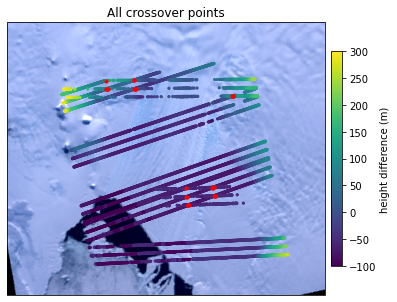

In [26]:
lon_xovers_proj, lat_xovers_proj = coor2coor('4326', '3031', out['o_lon'], out['o_lat'])

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], \
                        color_bands=(0, 1, 2), clip_percent=2, focus=[0.3, 0.8, 0.2, 0.8])
plt.scatter(x_as[::10], y_as[::10], c=h_as[::10], s=5, cmap='viridis')
plt.scatter(x_des[::10], y_des[::10], c=h_des[::10], s=5, cmap='viridis')
### all crossover points
plt.scatter(lon_xovers_proj, lat_xovers_proj, s=10, c='red')
plt.clim([-100.,300.])
plt.colorbar(fraction=0.0320, pad=0.02, label='height difference (m)')
plt.title('All crossover points')


### Statistic of the heights difference at the crossover point (between ascending and descending orbits).


Text(0.5, 0, 'dh_xovers')

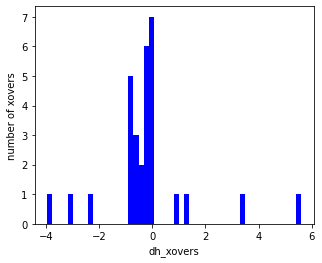

In [20]:
fig = plt.figure(figsize=(5, 4))
n_as, bins_as, patches_as = plt.hist(out['oh_dif'], 50, facecolor='blue')
plt.ylabel('number of xovers'); plt.xlabel('dh_xovers')


### Calculate the ice change rate by using the resulted dh and dt at the crossover point.

In [10]:
## filtering invalid points, np.abs(dh) < 5
idx_valid, = np.where( (np.abs(out['oh_dif']) <= 5) )
lon_xovers, lat_xovers = out['o_lon'][idx_valid], out['o_lat'][idx_valid]
dt_xovers, dh_xovers = out['ot_dif'][idx_valid], out['oh_dif'][idx_valid]
dhdt_xovers = dh_xovers/dt_xovers  # ice change rate


Text(0.5, 0, 'dhdt_xovers (m/year)')

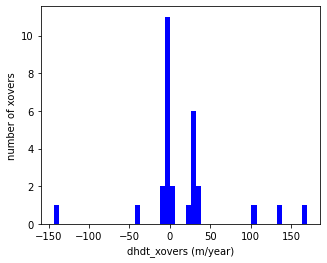

In [23]:
fig = plt.figure(figsize=(5, 4))
n_as, bins_as, patches_as = plt.hist(dhdt_xovers, 50, facecolor='blue')
plt.ylabel('number of xovers'); plt.xlabel('dhdt_xovers (m/year)')
